# Problem 1: Laplace approximation for the Gamma-Poisson model

Let us consider the exact same model and data as in the previous exercise set:
\begin{align*}
x_n &\sim \text{Poisson}(uv),\\
u &\sim \text{Gamma}(6, 1),\\
v &\sim \text{Gamma}(3, 3).
\end{align*}
where individual observations $\mathbf{x}=[5, 3, 9, 13, 5, 3, 5, 1, 2, 7, 6, 5, 6, 7, 4]$ are conditionally independent of each other. 

Now we use distributional methods to approximate the posterior, instead of sampling from it. The first problem is about Laplace approximation.

1. Find the **Laplace approximation** for the posterior. First find the maximum of $\log p(\mathbf{x},u,v)$ with respect to $u$ and $v$ with any algorithm (e.g. gradient-descent) and then compute the precision matrix as the negative of the Hessian of the same density, evaluated at $\hat u, \hat v$ that correspond to the optimum.
2. **Compare the approximation with the results of Gibbs or Metropolis** (last week), paying particular attention into the tails of the distribution. Explain your main findings: How do the results differ and would you be happy to use the approximation here? 

For computing the Hessian you can either compute the second derivatives manually (recommended; remember to return also scans of your derivation) or use automatic differentiation in PyTorch (if familiar with that), or both -- then you can check whether your derivations are correct.

In [1]:
#imports

import numpy as np
import numpy.random as npr
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
import scipy.special as sps
import torch

%matplotlib inline

theoretical: u=5.777213725647858 and v=0.925737908549286
torch: u=5.777116775512695 and v=0.9257529377937317
theoretical Hessian: tensor([[ -2.5767, -15.0000],
        [-15.0000, -96.8505]], dtype=torch.float64)
torch Hessian: tensor([[ -2.5768, -15.0000],
        [-15.0000, -96.8474]])
precision matrix: tensor([[ 2.5767, 15.0000],
        [15.0000, 96.8505]], dtype=torch.float64)


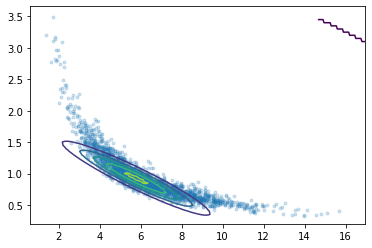

In [2]:
x = np.array([5, 3, 9, 13, 5, 3, 5, 1, 2, 7, 6, 5, 6, 7, 4])
N = len(x)
sum_x = np.sum(x)

# Step 1:
# Define the model, using the log-density as before
# logdensity = ...
        
# params=[u, v]
def log_density(params, x=x):
    N = len(x)
    return (5+sum_x)*torch.log(params[0]) + (2+sum_x)*torch.log(params[1]) - params[0] - 3*params[1] - N*params[0]*params[1]

# Step 2:
# Find the best point estimate, used as the mean of the approximation
# Hint: You can do this in the same way as in Exercise 1 where you optimized logistic regression in PyTorch
# uhat = ...
# vhat = ...

# Theoretical values of uhat and vhat
v_discriminant = (N+1)**2 - 4*N*(-2-sum_x)/3

# We take the positive solution because the log-density has log(u) and log(v)
theo_vhat = (-(N+1) + np.sqrt(v_discriminant))/(2*N)
theo_uhat = 3*(theo_vhat+1)

# PyTorch uhat and vhat
# Define the optimization algorithm
params = [torch.tensor([0.8, 1.2], requires_grad=True)]
optimizer = torch.optim.SGD(params, lr=0.01)

# Optimization loop
for i in range(5000):
    optimizer.zero_grad()
    loss = -log_density(params[0])
    loss.backward()
    optimizer.step()

# Get the maximum value
torch_uhat, torch_vhat = params[0].detach()

print(f"theoretical: u={theo_uhat} and v={theo_vhat}")
print(f"torch: u={torch_uhat} and v={torch_vhat}")

# Step 3:
# Determine the covariance of the approximation
# - Compute all second derivatives
# - Convert to the covariance
# Covhat = ...

in_tensor = torch.tensor([torch_uhat, torch_vhat])
torch_hess = torch.autograd.functional.hessian(log_density, in_tensor)

theo_hess = torch.tensor([[-(5+sum_x)/theo_uhat**2, -N],
                          [-N, -(2+sum_x)/theo_vhat**2]])

precision = -theo_hess

print(f"theoretical Hessian: {theo_hess}")
print(f"torch Hessian: {torch_hess}")
print(f"precision matrix: {precision}")

#
# EXAMPLE PLOTTING CODE THAT MAY BE HELPFUL
#

def Gibbs(log_density, param, T, x=x):
    # Storage for samples
    N = len(x)
    samples = param.copy()
    for t in range(T):
        # Sample u conditional on v
        param[0] = np.random.gamma(6 + np.sum(x), 1./(1+N*param[1]))

        # Storing the sample already after updating the mean allows better visualization of
        # what is going on, but is not useful in real use
        #samples = np.vstack([samples, param])
        
        # Sample v conditional on u
        param[1] = np.random.gamma(3 + np.sum(x), 1./(3 + N*param[0]))

        samples = np.vstack([samples, param])
    return samples

ugrid = np.arange(2,17,0.05)
vgrid = np.arange(0.2,3.5,0.05)
uset, vset = np.meshgrid(ugrid, vgrid)
uv = np.column_stack([uset.flat, vset.flat])

# Density values at the grid points
pdf_laplace = stats.multivariate_normal(np.array([theo_uhat,theo_vhat]), torch.inverse(precision)).pdf(uv).reshape(uset.shape)

# Add some Gibbs samples on top to compare
gibbs_samples = Gibbs(x, [3.0, 0.5], 2500)
plt.plot(gibbs_samples[500:,0], gibbs_samples[500:,1], '.', alpha=0.2)

# Then plot the countours 
_ = plt.contour(uset, vset, pdf_laplace, levels=6)


## Gibbs vs approximation

We can see that the approximation is able to capture most of the mass of the original distribution; however, it is not able to replicate the geometry or structure of the true distribution, and this is very apparent on the tails. This is due to the restriction on the shape imposed by the approximation's model, since a normal distribution isn't able to "bend" in the same manner as the true distribution.

In such a simple example with only 2 dimensions it may not be worth it to use the approximation, since the Gibbs sampler can give way more precise results without a lot of additional computational overhead. However, if we were using way more complex models in settings with higher dimensions, using an approximation can be *way* easier and requires considerably less resources (specially time). Reiterating, the approximation is capable of capturing the majority of the mass of the original distribution, so we could be content with using it in these settings.

# Problem 2: Variational approximation for the Gamma-Poisson model

Continue still with the exact same model. Now we form a variational approximation for the posterior using the coordinate-ascent VI method (CAVI).

As the approximation we use $q(u,v|\lambda) = q(u|a,b) q(v|c,d)$ where $\lambda=\{a,b,c,d\}$ are the parameters of the approximation. 

1. **Figure out the update rules** for the approximation parameters $\lambda$, starting from the conditional distributions $p(u|\mathbf{x},v)$ and $p(u|\mathbf{x},v)$ derived in the previous exercise. The update rule for $q(u|a,b)$ builds on $p(u|\mathbf{x},v)$ but rather than conditioning on a specific value of $v$ we need to integrate $\log p(u|\mathbf{x},v)$ over the current $q(v|c,d)$. Return your derivations.
2. **Write code that implements CAVI**, using the update equations. Note that you need to initialize your algorithm with some vlaues for the $\lambda$ -- think about how to do this, to avoid very bad initializations.
3. **Compare the approximation with the results of Gibbs or Metropolis** (last week) and the Laplace approximation, again paying attention to the tails. Explain briefly your main findings. How does the variational approximation differ from Laplace? Which one would you prefer here?

[87, 15.000873399399522]
[84, 89.99493457842519]


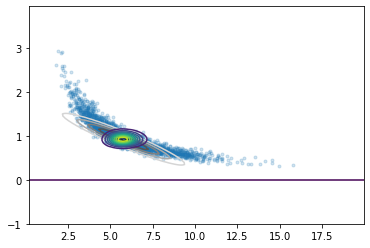

In [3]:
# Iterative optimization of q_u and q_v

prior_alpha_u = 6
prior_beta_u = 1
prior_alpha_v = 3
prior_beta_v = 3

# Definte the approximation
# Assume factorized q(mu,sigma) = q(mu|m,s) q(sigma|a,b) (normal and gamma)
# params for u: a, b
q_u_param = [prior_alpha_u + sum_x, 20.0]

# params for v: c, d
q_v_param = [prior_alpha_v + sum_x, 20.0]

q_u = stats.gamma(q_u_param[0], scale=1.0/q_u_param[1])
q_v = stats.gamma(q_v_param[0], scale=1.0/q_v_param[1])

# Perform optimization; note how few iterations are enough here
for iter in range(100):
    ### Update q_u
    # Compute required expectations
    E_v = q_v.mean()
    # If we were to implement the ELBO, we would also need the following expectation that is not
    # implemented in scipy.stats
    #E_log_prec = np.log(q_prec_param[1]) + scipy.special.digamma(q_prec_param[0])
    
    # Update the parameters
    q_u_param[1] = prior_beta_u + N*E_v
    q_u = stats.gamma(q_u_param[0], scale=1./q_u_param[1])
    
    ### Update q_v
    # Compute required expectations
    E_u = q_u.mean()
    
    # Update the parameters
    q_v_param[1] = prior_beta_v + N*E_u
    q_v = stats.gamma(q_v_param[0], scale=1./q_v_param[1])

    
print(q_u_param)
print(q_v_param)
ugrid = np.arange(0.2,20,0.05)
vgrid = np.arange(-1,4,0.05)
uset, vset = np.meshgrid(ugrid, vgrid)

# For the plotting you can get the density with something like the following, assuming your q_u and q_v are common distributions
pdf_VI = (q_u.pdf(uset)*q_v.pdf(vset)).reshape(uset.shape)

# Density values at the grid points
ugrid_lap = np.arange(2,13,0.05)
vgrid_lap = np.arange(0.2,3.5,0.05)
uset_lap, vset_lap = np.meshgrid(ugrid_lap, vgrid_lap)
uv = np.column_stack([uset_lap.flat, vset_lap.flat])
pdf_laplace = stats.multivariate_normal(np.array([theo_uhat,theo_vhat]), torch.inverse(precision)).pdf(uv).reshape(uset_lap.shape)

# # Add some Gibbs samples on top to compare
gibbs_samples = Gibbs(x, [3.0, 0.5], 2500)
plt.plot(gibbs_samples[500:,0], gibbs_samples[500:,1], '.', alpha=0.2)

# # Then plot the countours 
_ = plt.contour(uset_lap, vset_lap, pdf_laplace, levels=6, cmap="binary")

# # Then plot the countours
_ = plt.contour(uset, vset, pdf_VI, levels=10, cmap="viridis")

## Comparison
As we can see, the approximation using variational inference is putting the majority of its mass in a very restricted region. There are two main reasons that our approximation is considerably off from our target: the mean-field approximation and properties from the KL divergence. The mean-field approximation makes it so that we can't really represent correlation, so we can't "twist" our approximation as we did with the Laplace approximation, whereas the KL divergence heavily penalizes distributions that are non-zero when the original distribution is close to zero, which means that our approximation can't "go wide" to cover more of the original distribution. Both of these reasons heavily restrict our approximation, which results in a distribution that isn't able to capture the geometry of the original distribution very well (as we can see comparing the distribution contour, in viridis colormap, with the Gibbs samples and the Laplace approximation, in binary colormap). In particular, the tails would be extremely hard to represent well with our variational inference with the mean-field approximation.

Nevertheless, if we wish to get an approximation that represents a good proportion of the mass of the original distribution, the mean-field approximation gives a very easy algorithm to implement to give such an approximation. Depending on our use-case it may be fine to use such a model, but in this low-dimensional and highly correlated distribution it is not the best.

# Problem 3: Variational approximation for mixture models

Your task is to derive and implement CAVI algorithm for a mixture of univariate Gaussians. Section 28.2.1 in Murphy's book explains the model briefly and Section 10.2.6 covers variational inference for a more general (multivariate) mixture model. Start by reading these sections.

The model is defined as
\begin{align*}
p(\boldsymbol{\pi}|\alpha) &= \text{Dirichlet}(\alpha)\\
p(\mu_k|\tau_0) &= \mathcal{N}(0, \tau_0)\\
p(\tau_{k}|\alpha_0, \beta_0) &= \text{Gamma}(\alpha_0, \beta_0)\\
p(z_n|\boldsymbol{\pi}) &= \text{Categorical}(\boldsymbol{\pi})\\
p(x_{n}|\{\mu\},\{\tau\}, z_n) &= \mathcal{N}(\mu_{z_n},\tau_{z_n})
\end{align*}
where $\tau$ is precision. The notation $\mu_{z_n}$ on the last row indicates we use the mean of the $z_n$:th cluster. The joint likelihood and the conditional distributions needed for a Gibbs sampler are provided below as a starting point to make derivation of variational updates easier. 

If we write the joint likelihood of cluster allocations and data as
\begin{align*}
p(x_n,z_n|\dots) = \left (\prod_k p(z_n|\boldsymbol{\pi})   p(x_n|\mu_{k},\tau_{k}) \right )^{I[z_n=k]},
\end{align*}

we get a nice expression for the log-density as

\begin{align*}
\log 
& \left [ \prod_n \prod_k \left ( p(z_n|\boldsymbol{\pi}) p(x_{n}|\mu_{z_n},\tau_{z_n})\right )^{I[z_n=k]} \right ]
\left [ \prod_k p(\mu_k)p(\tau_k) \right ]
p(\boldsymbol{\pi})\\
= &
\sum_n \sum_k  \mathbb{I}[z_n=k] \left [ \log \pi_k + \left ( -\frac{1}{2} \log (2\pi) + \frac{1}{2} \log \tau_{d} - \frac{1}{2} \tau_{d} (x_{d} - \mu_{d})^2 \right ) \right ]\\
&+ 
\sum_k \left ( -\frac{1}{2}\log (2\pi) + \frac{1}{2}\log \tau_0 - \frac{1}{2} \tau_0 \mu_{k}^2 +  \alpha_0 \log (\beta_0) - \Gamma(\alpha_0) + (\alpha_0-1) \log (\tau_{k}) - \beta_0 \tau_{k} \right )\\
&+
\sum_k (\alpha-1) \log \pi_k - \log B(\alpha).
\end{align*}
Note that $\pi$ in $\log (2\pi)$ is the mathematical constant, not the parameter.

Simple algebraic manipulation of the joint density gives the conditional distributions:
\begin{align*}
p(\pi|\boldsymbol{z},\alpha) &= \text{Dirichlet}\left(\alpha + \sum_k I[z_n=k]\right) = \text{Dirichlet}(\alpha + N_k),\\
p(\tau_k|\dots) &= \text{Gamma}\left(\alpha_0 + \frac{1}{2}N_k, \beta_0 + \frac{1}{2} \sum_n \mathbb{I}(z_n=k) (x_{n} - \mu_{k})^2 \right),\\
p(\mu_{k}|\dots) &= \mathcal{N} \left( \frac{\tau_k \sum_n I[z_n=k] x_{n}}{\tau_0 + N_k \tau_k}, \tau_0 + N_k\tau_k \right),\\
p(z_n=k|x_n,\dots) &=  \frac{e^{\nu_{nk}}}{\sum_j e^{\nu_{nj}}}
\end{align*}
where 
\begin{align*}
\nu_{nk} = 
 \log p(z_n=k|x_n,\dots) \propto \log \pi_k + \left ( -\frac{1}{2} \log (2\pi) + \frac{1}{2} \log \tau_{k} - \frac{1}{2} \tau_{k} (x_{n} - \mu_{k})^2 \right ) 
\end{align*}
and $N_k$ is always the number of samples currently allocated for each cluster. In most cases these conditionals follow directly from the simple Gaussian model we covered in the lectures, but now we just need to consider only the samples that belong to this cluster. Note that each sample is always allocated to a single cluster determined by $z_n$, but the allocation naturally changes during the sampling.


Below is a snippet of code that samples data from this model and visualizes it with histograms. The left plot has separate histogram for the samples of each cluster, whereas the right one shows the full data histogram. In real use cases we naturally do not know the true $z_n$ so we could not draw the left plot.

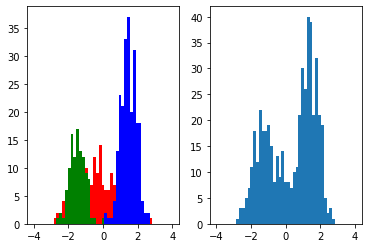

In [4]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

np.random.seed(7879)

# Define the model
# This time we specify the model parameters directly rather than sampling from the prior,
# to avoid e.g. two clusters with almost identical means.
K = 3
pi_true = np.array([0.35, 0.2, 0.45])
mu_true = np.array([0., -1.5, 1.5])
tau_true = np.array([1., 5., 5.])

# Sample data
N = 500
x = np.zeros((N,))
z_true = stats.multinomial(1,pi_true).rvs(N) # one-hot-encoding for easier implementation
colors = ['r','g','b']
plt.subplot(1,2,1)
for k in range(3):
    x[z_true[:,k]==1] = stats.norm(mu_true[k], 1./np.sqrt(tau_true[k])).rvs(sum(z_true[:,k]))
    plt.hist(x[z_true[:,k]==1], color=colors[k], bins=np.linspace(-4.,4.,50))
plt.subplot(1,2,2)
_ = plt.hist(x,bins=np.linspace(-4.,4.,50))

Your task is to derive and implement mean-field VI for this model, using the approximation
\begin{align*}
q(\boldsymbol z, \boldsymbol{\pi}, \boldsymbol \tau, \boldsymbol \mu) =  \prod_n \left [ q(z_n|\boldsymbol \xi_n) \right ] q(\boldsymbol{\pi}|\boldsymbol{\eta}) \prod_k \left [ q(\tau_k|a_k,b_k) q(\mu_k|m_k, t_k) \right ]
\end{align*}
Here $q(z)$ are categorical, $q(\pi)$ is Dirichlet, $q(\tau)$ are gamma, and $q(\mu)$ are normal. Note that we have $N$ copies of $q(z)$, one for each sample, and $K$ copies of $q(\mu)$ and $q(\tau)$, one for each cluster.

1. **Derive the update rules for all approximation terms**. Start from the conditional distributions provided above and proceed in the same way as in the 2nd problem. Note that Murphy's book gives the correct updates for a more general mixture model in Section 10.2.6. You can follow those derivations but remember that our model is a bit simpler.

2. **Implement the CAVI algorithm** and run it on the synthetic data generated above. The code snippet below already defines the approximations and provides one example of how to initialize the approximation terms.

3. **Analyse the results**. How does the algorithm converge? What does the posterior approximation look like?

HINTS:
1. The lecture notebook already shows code for an individual normal distribution and the recorded lecture went through the derivations. You can build on those for the updates for $q(\mu)$ and $q(\tau)$.
2. In Gibbs sampler the equations for $\mu_k$ and $\tau_k$ sum over the samples currently allocated into this cluster (that is, $z_n=k$). Now we have a distribution $q(z_n)$ instead, which can be interpreted as soft memberships. In practice, we always sum over all samples when updating the approximation term for any cluster, but the data points belong to each cluster only partially (and often $q(z_n==k) \approx 0$ for many $k$).
3. For updating $q(z)$ you again need the log-sum-exp trick to avoid underflows
4. You will need some non-trivial expectations (in particular, expectation of log of a specific random variable). You should easily find an expression for that with google.

In [66]:
# Hyperparameters (you can use these values or some others if you wish)
nIter = 100
K = 3
alpha = 1.
alpha0 = 0.5
beta0 = 0.5
tau0 = 0.1

# Define and initialize approximation
eta = np.full(K, N/K)              # Equal probability for all clusters in the beginning

xi = stats.dirichlet(eta).rvs(N)   # Each row of xi needs to sum up to one

a = np.full((K,), 3.)             # We don't care too much about initial precisions but avoid very large values
b = np.full((K,), 5.)

m = stats.norm(0., 3.).rvs((K,))  # Need to start with different ones to break symmetry
t = np.full((K,), 5.)             # Some uncertainty in beginning

# Now you can define the distributions with something like
# q_tau = stats.gamma(a,b)
# which enables querying most of the needed expectations with expressions like q_tau.mean()
# Alternatively, you can just directly compute the expectations; mean(q_tau) = a/b etc.

# To encode the values of z_n later
one_hot_cluster = [np.array([1, 0, 0]), np.array([0, 1, 0]), np.array([0, 0, 1])]

# Initial values
N_k = np.zeros(K)
z = np.zeros((N, K))
tau = stats.gamma(a, 1./b).mean()
mu = stats.norm(m, 1./np.sqrt(t)).mean()

history = []
history.append([eta, m.copy(), t.copy(), a.copy(), b.copy()])
track_history = True

# Might be a good idea to store the parameters after each iteration, to monitor the convergence
# However, you might not want to store the biggest matrices (xi).
for i in range(nIter):
    # Update q(z)
    for n in range(N):
        eta_portion = sps.digamma(eta) - sps.digamma(np.sum(eta))
        tau_portion = -np.log(b) + sps.digamma(a)
        mixed_portion = (a/b)*(x[n] - 2*x[n]*m + m**2 + 1./t)
        nu = eta_portion - 0.5*np.log(2*np.pi) + 0.5*tau_portion - 0.5*mixed_portion
        update = np.exp( nu - sps.logsumexp(nu) )
        # xi[n,:] = update**(one_hot_cluster[z_nk])
        xi[n, :] = update
        
        z[n] = one_hot_cluster[np.random.choice(K, 1, p=update)[0]]
        
    N_k = np.sum(z, axis=0)
    
    # Update q(pi)
    eta = alpha*np.ones(K) + N_k
        
    # Update cluster parameters
    for k in range(K):
        # Precision
        tau_sum_term = 0
        for n in range(N):
            # tau_sum_term += z[n][k] * (x[n] - mu[k])**2
            tau_sum_term += xi[n][k] * (x[n]**2 - 2*x[n]*m[k] + m[k]**2 + 1./t[k])
        a[k] = alpha0 + 0.5*N_k[k]
        b[k] = beta0 + 0.5*tau_sum_term
        # tau[k] = stats.gamma(a[k], scale=1./b[k]).mean()
        tau[k] = a[k]/b[k]
        
        # Mean
        mu_sum_term = 0
        for n in range(N):
            # mu_sum_term += z[n][k] * x[n]
            mu_sum_term += xi[n][k] * x[n]
        m[k] = (tau[k]*mu_sum_term)/(tau0 + N_k[k]*tau[k])
        t[k] = tau0 + N_k[k]*tau[k]
        
    # history[i,:] = np.concatenate([eta, m, t, a, b])
    if track_history:
        history.append([eta, m.copy(), t.copy(), a.copy(), b.copy()])

# print(history[99][0])
# print(history[99][1])
# print(history[99][2])
# print(history[99][3])
# print(history[99][4])

mu = m

print(f"Estimated mu mean: {mu}")
print(f"True mu values: {mu_true}")

print(f"Estimated tau expected value: {tau}")
print(f"True tau values: {tau_true}")

Estimated mu mean: [-1.38299708 -0.01953959  1.46360246]
True mu values: [ 0.  -1.5  1.5]
Estimated tau expected value: [3.04004363 3.06118216 4.45072042]
True tau values: [1. 5. 5.]


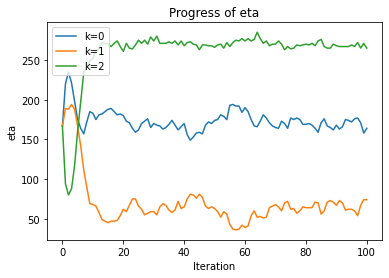

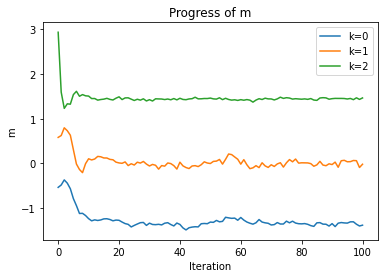

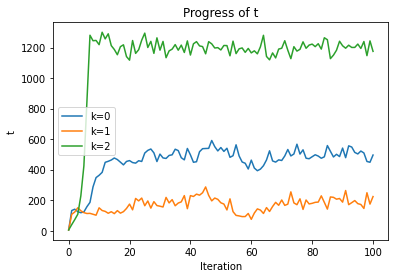

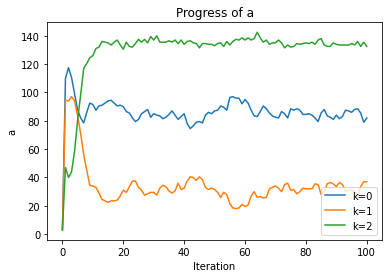

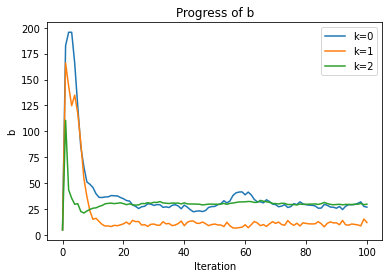

In [67]:
np_history = np.array(history)

labels = ["eta", "m", "t", "a", "b"]

def plot_history(history):
    iterations = range(nIter+1)
    for i in range(5):
        for k in range(K):
            plt.plot(iterations, history[:, i, k], label=f"k={k}")
        plt.title(f"Progress of {labels[i]}")
        plt.xlabel("Iteration")
        plt.ylabel(f"{labels[i]}")
        plt.legend()
        plt.show()
    return
plot_history(np_history)

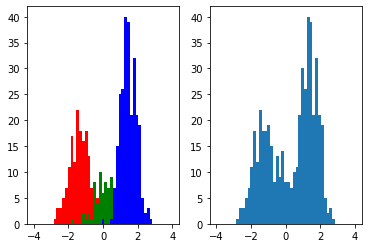

In [68]:
# Sample data
N = 500
x_vi = np.zeros((N,))
z_vi = np.zeros((N, K))
for n in range(N):
    z_vi[n] = stats.multinomial(1,xi[n]).rvs()
colors = ['r','g','b']
mu_vi = npr.normal(m, 1./np.sqrt(t))
tau_vi = npr.gamma(a, scale=1./b)
plt.subplot(1,2,1)
for k in range(3):
    x_vi[z_vi[:,k]==1] = stats.norm(mu_vi[k], 1./np.sqrt(tau_vi[k])).rvs(int(sum(z_vi[:,k])))
    plt.hist(x[z_vi[:,k]==1], color=colors[k], bins=np.linspace(-4.,4.,50))
    # plt.show()
plt.subplot(1,2,2)
_ = plt.hist(x,bins=np.linspace(-4.,4.,50))